# Rozpoznawanie ras psów z wykorzystaniem biblioteki Keras
### Michał Foryt, Szczepan Gabiec, Paweł Wróblewski

<img src="meme2.jpg" style="width: 400px;">

Celem projektu jest stworzenie algorytmu służącego do rozpoznawaniu ras psów porzy wykorzystaniu biblioteki Keras, w oparciu o TensorFlow. Zbiór z którego korzystaliśmy pochodzi z jednego z konkursów zorganizowanych przez portal Kaggle i znajduje się pod tym linkiem: https://www.kaggle.com/c/dog-breed-identification. Z uwagi na jego rozmiar (~750MB) nie bedzie on dołączony bezpośrednio do kodu.  

W skład zbioru wchodzi około 10 tysięcy zdjęć, a wśród nich można wyróźnić 120 klas (ras psów). Pracując na tych danych, będziemy mogli stworzyć algorytm bazujący na głębokim uczeniu sieci neuronowych. W dużym uproszczeniu, zadaniem tego typu algorytmu jest rozpoznawanie obrazów podobnie, jak robi to umysł ludzki - "oglądając" ogromną pulę zdjęć z czasem rozpoznaje charakterystyczne cechy dla danego obiektu, przykładowo że rottweilera można poznać po tym, że jest duży i ma krótką, ciemną sierść, a york ma krótkie łapy i jest mocno owłosiony. Innymi słowy, algorytm najpierw zbiera dużą ilość danych, a następnie pozwala komputerowi zapoznać się z każdym z nich. Opierając się na dużych bazach danych i zauważając pojawiające się wzorce, komputery mogą rozpoznać obrazy i sformułować odpowiednie tagi i kategorie.

Formalnie można nakreślić następujacy przebieg metody:
- Na wejściu algorytm otrzymuje zbiór zawierający N obrazów, każdy z nich przypisany jest do jednej z K klas. 
- Następnie wykorzystuje się zbiór treningowy do szkolenia klasyfikatora tak, aby był on w stanie jak najepiej przyporządkować etykietę do zdjęcia.
- Na koniec ocenia się jakość klasyfikatora, prosząc go o przewidywanie etykiet dla nowego zestawu obrazów, których nigdy wcześniej nie widział, po czym porównamy prawdziwe etykiety tych obrazów z przewidywanymi przez klasyfikator.


## Konwolucyjne Sieci Neuronowe 
Konwolucyjne Sieci Neuronowe (ang. <i>CNN, Convolutional neural networks</i>, tłumaczone także jako <i>Splotowe Sieci Neuronowe</i>) w sprytny sposób redukują liczbę przyjmowanych parametrów. Zamiast działać na sieci, w której neurony są połączone każdy z każdym, podejście jakie prezentują CNN wykorzystują wielokrotnie te same parametry. Kluczem do sukcesu konwolucyjnych sieci jest fakt, że wychodza one z założenia, że wystarczy lokalne zrozumienie obrazu. Innymi słowy, algorytm skupia się na tym, by  stopniowo filtrować różne części danych uczących i wyostrzać ważne cechy w procesie dyskryminacji wykorzystanym do rozpoznawania lub klasyfikacji wzorców. W praktyce zaletą takiego podejścia jest posiadanie mniejszej liczby parametrów, co przekłada się na znaczne zmniejszenie czasu potrzebnego do wytrenowania modelu.

Rozważmy obraz o wymiarze 256 × 256 pikseli. Zamiast przetwarzać cały obraz naraz, CNN może skutecznie skanować go po kawałku - powiedzmy, patrząc na fragment o wymiarach 5 × 5. Taka ramka o wymiarach 5 × 5px przesuwa się wzdłuż obrazu (zwykle od lewej do prawej i od góry do dołu), jak pokazano na poniższym rysunku. 

<img src="cnn_concept.jpeg" style="width: 350px;">

Tempo przesuwania się takiej ramki nazywamy "długością kroku". Na przykład długość kroku 2 oznacza, że okno 5 × 5 przesuwa się o 2 piksele na raz, aż obejmie cały obraz. Taka ramka 5 x 5 pikseli przekłada się na macierz wag o wymiarze 5 x 5. 

Tego typu operacja ma miejsce w warstwie konwolucyjnej sieci neuronowej. Typowa CNN posiada wiele tego typu warste. Każda z nich zazwyczaj generuje wiele różnych splotów (ang. <i>convolutions</i>). Co za tym idzie, macierz wagowa takiego tensora (czyli obiektu matematycznego będącego uogólnieniem pojęcia wektora) ma wymiary 5 × 5 x n, gdzie n liczbą konwolucji (splotów).

Przykładowo, załóżmy że przepuszczamy rozważany obraz przez pojedynczą warstwę splotu jako macierz wagowa 5 x 5 x 64 z ramką 5 x 5. Co za ty idzie, taki model posiada 5 x 5 x64 = 1600 parametrów, podczas gdy pełna sieć dla obrazu 256 x 256px wymagałaby zastosowania 65 536 parametrów.

## Obróbka zbioru danych
Jak już wspomnielismy na początku, wykorzystamy zbiór danych dotyczący rozpoznawania ras psów, który wstępnie został już podzielony na zbiór treningowy i testowy. Nazwa każdego z obrazów jest też jednocześnie jego unikalnym id. Cały zestaw danych zawiera zdjęcia 120 ras, jednak dla urposzczenia modelu przyjmiemy założenie, że ograniczamy się jedynie do rozpoznawania 8 najpopularniejszych.

Dla porządku, wszystkie niezbędne importy zastosujemy poniżej. Dzięki temu uzyskamy większa czytelność oraz podcas tworzenia naszej funkcjonalności będziemy mieli pewność, że wszystkie niezbędne paczki zostały już ściągnięte.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
import matplotlib.pyplot as plt
from shutil import copyfile
#%matplotlib inline

Następnie rozpakowujemy dane testowe i treningowe.

In [2]:
labels = pd.read_csv('labels.csv')

In [3]:
labels_dict = {i:j for i,j in zip(labels['id'],labels['breed'])}
classes = set(labels_dict.values())
images = [f for f in os.listdir('train')]

In [4]:
if not os.path.exists('training_images'):
        os.makedirs('training_images')

if not os.path.exists('validation_images'):
    os.makedirs('validation_images')

In [5]:
os.chdir('training_images')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)
        #os.rmdir(curClass)

os.chdir('../validation_images')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)

In [6]:
os.chdir('..')
count = 0 
destination_directory = 'training_images/'
for item in images:
    if count >7999:
        destination_directory = 'validation_images/'
    filekey = os.path.splitext(item)[0]
    if  not os.path.exists(destination_directory+labels_dict[filekey]+'/'+item):
        copyfile('train/'+item, destination_directory+labels_dict[filekey]+'/'+item)
    print(labels_dict[filekey])
    count +=1

chow
french_bulldog
redbone
chesapeake_bay_retriever
scottish_deerhound
redbone
basset
lakeland_terrier
shetland_sheepdog
cardigan
bluetick
tibetan_terrier
mexican_hairless
bedlington_terrier
groenendael
italian_greyhound
golden_retriever
italian_greyhound
komondor
lhasa
borzoi
sealyham_terrier
whippet
african_hunting_dog
samoyed
miniature_pinscher
pekinese
german_short-haired_pointer
afghan_hound
kuvasz
eskimo_dog
rottweiler
basenji
african_hunting_dog
airedale
australian_terrier
maltese_dog
great_pyrenees
greater_swiss_mountain_dog
toy_terrier
pug
bluetick
samoyed
italian_greyhound
samoyed
shih-tzu
miniature_pinscher
bouvier_des_flandres
afghan_hound
soft-coated_wheaten_terrier
newfoundland
wire-haired_fox_terrier
scotch_terrier
shih-tzu
lakeland_terrier
basenji
rottweiler
shih-tzu
chow
briard
basenji
whippet
japanese_spaniel
kuvasz
clumber
walker_hound
bernese_mountain_dog
bernese_mountain_dog
bernese_mountain_dog
irish_wolfhound
keeshond
kerry_blue_terrier
basenji
irish_water_spani

scottish_deerhound
bluetick
standard_poodle
komondor
cairn
affenpinscher
silky_terrier
weimaraner
pembroke
dingo
french_bulldog
toy_terrier
irish_terrier
pomeranian
great_dane
old_english_sheepdog
soft-coated_wheaten_terrier
entlebucher
cocker_spaniel
saint_bernard
german_shepherd
otterhound
labrador_retriever
west_highland_white_terrier
standard_poodle
great_dane
german_shepherd
siberian_husky
doberman
toy_poodle
cardigan
miniature_schnauzer
maltese_dog
samoyed
cardigan
bernese_mountain_dog
siberian_husky
norwegian_elkhound
kelpie
dandie_dinmont
beagle
pug
curly-coated_retriever
tibetan_terrier
beagle
tibetan_mastiff
groenendael
shih-tzu
tibetan_terrier
clumber
bouvier_des_flandres
irish_water_spaniel
pekinese
border_collie
basset
miniature_schnauzer
scottish_deerhound
pekinese
soft-coated_wheaten_terrier
saluki
french_bulldog
clumber
rhodesian_ridgeback
italian_greyhound
afghan_hound
whippet
bedlington_terrier
collie
great_pyrenees
german_shepherd
english_setter
african_hunting_dog
m

border_collie
italian_greyhound
curly-coated_retriever
great_dane
newfoundland
australian_terrier
toy_terrier
pekinese
whippet
samoyed
french_bulldog
flat-coated_retriever
golden_retriever
saluki
yorkshire_terrier
cocker_spaniel
miniature_pinscher
boston_bull
dandie_dinmont
blenheim_spaniel
border_terrier
keeshond
soft-coated_wheaten_terrier
pomeranian
german_short-haired_pointer
borzoi
cocker_spaniel
chow
beagle
west_highland_white_terrier
saint_bernard
pomeranian
norwegian_elkhound
sealyham_terrier
sealyham_terrier
basenji
toy_terrier
pug
german_shepherd
bloodhound
shih-tzu
brabancon_griffon
affenpinscher
rottweiler
cocker_spaniel
italian_greyhound
saint_bernard
norfolk_terrier
silky_terrier
old_english_sheepdog
miniature_poodle
afghan_hound
norwegian_elkhound
weimaraner
shih-tzu
bernese_mountain_dog
brittany_spaniel
shih-tzu
irish_water_spaniel
german_short-haired_pointer
pembroke
italian_greyhound
komondor
norwich_terrier
boston_bull
samoyed
english_foxhound
pomeranian
eskimo_dog
s

affenpinscher
beagle
ibizan_hound
bluetick
pekinese
irish_terrier
silky_terrier
malamute
whippet
lhasa
miniature_pinscher
brittany_spaniel
schipperke
dandie_dinmont
appenzeller
french_bulldog
whippet
bouvier_des_flandres
standard_schnauzer
ibizan_hound
japanese_spaniel
bull_mastiff
affenpinscher
miniature_schnauzer
basenji
miniature_poodle
saint_bernard
dandie_dinmont
briard
norwich_terrier
bouvier_des_flandres
basset
boston_bull
pug
keeshond
ibizan_hound
dandie_dinmont
german_shepherd
samoyed
lakeland_terrier
boxer
collie
siberian_husky
papillon
german_shepherd
english_springer
scotch_terrier
miniature_poodle
mexican_hairless
miniature_poodle
maltese_dog
welsh_springer_spaniel
whippet
dhole
gordon_setter
kelpie
rhodesian_ridgeback
papillon
pug
wire-haired_fox_terrier
lakeland_terrier
scottish_deerhound
pembroke
shetland_sheepdog
curly-coated_retriever
wire-haired_fox_terrier
german_shepherd
welsh_springer_spaniel
vizsla
lhasa
komondor
brabancon_griffon
great_dane
keeshond
english_sett

siberian_husky
west_highland_white_terrier
brabancon_griffon
dhole
shih-tzu
shetland_sheepdog
newfoundland
border_terrier
staffordshire_bullterrier
golden_retriever
siberian_husky
clumber
german_shepherd
pembroke
west_highland_white_terrier
mexican_hairless
walker_hound
norwich_terrier
affenpinscher
staffordshire_bullterrier
beagle
cardigan
groenendael
standard_schnauzer
irish_terrier
african_hunting_dog
toy_poodle
rottweiler
curly-coated_retriever
staffordshire_bullterrier
cardigan
malamute
giant_schnauzer
japanese_spaniel
scotch_terrier
curly-coated_retriever
saint_bernard
english_springer
australian_terrier
cairn
siberian_husky
pekinese
australian_terrier
miniature_poodle
airedale
giant_schnauzer
shih-tzu
keeshond
lakeland_terrier
malinois
shetland_sheepdog
gordon_setter
irish_terrier
saluki
old_english_sheepdog
dhole
lhasa
maltese_dog
appenzeller
saluki
pembroke
malinois
vizsla
wire-haired_fox_terrier
great_dane
dingo
shetland_sheepdog
great_dane
soft-coated_wheaten_terrier
irish_w

english_setter
yorkshire_terrier
norfolk_terrier
basset
shih-tzu
standard_poodle
leonberg
scottish_deerhound
afghan_hound
german_short-haired_pointer
rhodesian_ridgeback
west_highland_white_terrier
tibetan_terrier
flat-coated_retriever
entlebucher
otterhound
great_dane
newfoundland
chesapeake_bay_retriever
papillon
ibizan_hound
boxer
groenendael
redbone
sussex_spaniel
bouvier_des_flandres
italian_greyhound
whippet
rhodesian_ridgeback
standard_schnauzer
giant_schnauzer
german_shepherd
cairn
border_terrier
appenzeller
irish_terrier
malamute
walker_hound
appenzeller
miniature_poodle
lhasa
japanese_spaniel
great_pyrenees
rhodesian_ridgeback
australian_terrier
affenpinscher
italian_greyhound
komondor
brabancon_griffon
collie
malamute
lhasa
saint_bernard
tibetan_terrier
collie
bull_mastiff
west_highland_white_terrier
clumber
toy_poodle
yorkshire_terrier
english_setter
bedlington_terrier
briard
rottweiler
golden_retriever
sussex_spaniel
basset
otterhound
basset
samoyed
rhodesian_ridgeback
kom

english_springer
chesapeake_bay_retriever
norwegian_elkhound
saluki
siberian_husky
bedlington_terrier
chow
entlebucher
bluetick
shetland_sheepdog
cairn
samoyed
afghan_hound
german_shepherd
welsh_springer_spaniel
great_dane
sealyham_terrier
irish_setter
dandie_dinmont
rottweiler
brabancon_griffon
tibetan_terrier
cairn
scottish_deerhound
staffordshire_bullterrier
yorkshire_terrier
japanese_spaniel
japanese_spaniel
norwegian_elkhound
redbone
doberman
komondor
old_english_sheepdog
norwich_terrier
brittany_spaniel
clumber
border_collie
ibizan_hound
beagle
border_collie
eskimo_dog
dandie_dinmont
chesapeake_bay_retriever
keeshond
great_pyrenees
norfolk_terrier
borzoi
dingo
kerry_blue_terrier
english_foxhound
pekinese
tibetan_terrier
chesapeake_bay_retriever
black-and-tan_coonhound
briard
irish_setter
malinois
american_staffordshire_terrier
schipperke
shih-tzu
newfoundland
kerry_blue_terrier
border_collie
malamute
border_collie
chihuahua
whippet
collie
walker_hound
great_dane
irish_water_spani

## Image Augmentation


In [7]:
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('training_images/afghan_hound/0d5a88f0ab2db8d34b533c69768135e8.jpg') 
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0

if not os.path.exists('preview'):
        os.makedirs('preview')

for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='dog_breed', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

## Implementing Convolution Neural Network

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
#check class_mode in keras documentation https://keras.io/preprocessing/image/
training_set = train_datagen.flow_from_directory(
        'training_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

Found 8000 images belonging to 120 classes.
Found 2222 images belonging to 120 classes.


In [10]:
from tensorflow.keras.layers import Dropout
clf = Sequential()
#Convolution
#32 is number of kernals of 3x3, we can use 64 128 256 etc in next layers
#input shape can be 128, 256 later
clf.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu'))
#Max Pooling size reduces divided by 2
clf.add(MaxPooling2D(pool_size=(2,2)))      


#clf.add(Dropout(0.5))

clf.add(Conv2D(32,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
#clf.add(Dropout(0.25))

clf.add(Conv2D(64, (3, 3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2, 2)))
#clf.add(Dropout(0.10))
#Flattening
clf.add(Flatten())
        
#Adding An ANN
#lets take 128 hidden nodes in hidden layer
#clf.add(Dense(units=128,activation='relu'))
clf.add(Dense(units=64, activation='relu'))
clf.add(Dropout(0.5))
clf.add(Dense(units=120,activation='softmax'))
#stochastic gradient descent -Adam -optimizer
#loss func categorical cross entropy
#metrics = accuracy
clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor=EarlyStopping(patience=6)

In [12]:
hist=clf.fit_generator(
        training_set,
        steps_per_epoch=200,
        epochs=3,
        validation_data=test_set,
        validation_steps=222,
        callbacks=[early_stopping_monitor])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
200/200 [==============================] - 156s 779ms/step - loss: 4.7905 - binary_accuracy: 0.9917 - val_loss: 4.7879 - val_binary_accuracy: 0.9917
Epoch 2/3
200/200 [==============================] - 150s 750ms/step - loss: 4.7872 - binary_accuracy: 0.9917 - val_loss: 4.7853 - val_binary_accuracy: 0.9917
Epoch 3/3
200/200 [==============================] - 138s 688ms/step - loss: 4.7838 - binary_accuracy: 0.9917 - val_loss: 4.7845 - val_binary_accuracy: 0.9917


In [13]:
import os
import cv2
import pandas as pd
test_set = []
test_set_ids = []
for curImage in os.listdir('test'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    #print(os.path.splitext(curImage)[0])
    curImage = cv2.imread('test/'+curImage)
    test_set.append(cv2.resize(curImage,(128, 128)))

In [14]:
test_set = np.array(test_set, np.float32)/255.0

In [15]:
predictions = clf.predict(test_set)

In [16]:
predictions[0].shape

(120,)

In [17]:
training_set.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [18]:
classes= {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(120)]
column_names

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [19]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
#predictions_df.index = test_set_ids
predictions_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,264833ebf9f2bf8b07651f72916f8c75,0.008213,0.008840,0.008333,0.008635,0.008250,0.008190,0.008761,0.008976,0.008141,...,0.008375,0.008012,0.007958,0.008120,0.008200,0.008216,0.008253,0.008381,0.008519,0.008303
1,ae2b2271318cc84364931ada1c75b295,0.008210,0.008834,0.008330,0.008632,0.008248,0.008198,0.008755,0.008976,0.008139,...,0.008375,0.008014,0.007956,0.008116,0.008198,0.008216,0.008247,0.008382,0.008520,0.008303
2,35d9bcc10f2762ed900f7a2c48d37c15,0.008216,0.008841,0.008337,0.008636,0.008241,0.008192,0.008762,0.008980,0.008142,...,0.008378,0.008014,0.007958,0.008115,0.008196,0.008220,0.008251,0.008382,0.008521,0.008304
3,66fabb7f526d842a06829a770b959b9d,0.008216,0.008839,0.008334,0.008635,0.008254,0.008190,0.008766,0.008973,0.008140,...,0.008373,0.008012,0.007959,0.008120,0.008201,0.008213,0.008254,0.008383,0.008516,0.008303
4,cf5b51fe08e3337217fca120a03ac993,0.008214,0.008832,0.008336,0.008627,0.008239,0.008205,0.008754,0.008987,0.008142,...,0.008378,0.008009,0.007952,0.008106,0.008195,0.008217,0.008234,0.008379,0.008526,0.008303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,5dac8f13467994de6ba778df1cdba3fd,0.008218,0.008838,0.008335,0.008633,0.008253,0.008191,0.008767,0.008974,0.008139,...,0.008373,0.008010,0.007959,0.008118,0.008199,0.008210,0.008255,0.008385,0.008519,0.008303
10353,4064e9fe3249051177c27d4d505c1d83,0.008217,0.008839,0.008335,0.008635,0.008254,0.008189,0.008767,0.008972,0.008140,...,0.008372,0.008012,0.007959,0.008120,0.008201,0.008213,0.008254,0.008384,0.008515,0.008304
10354,a9fa08dfaec85e98387911dd4364ce79,0.008216,0.008838,0.008333,0.008634,0.008257,0.008190,0.008768,0.008971,0.008138,...,0.008372,0.008013,0.007960,0.008120,0.008202,0.008212,0.008255,0.008384,0.008515,0.008304
10355,3be602e5b58c0274b72ad5322d3c8601,0.008215,0.008840,0.008337,0.008635,0.008240,0.008195,0.008759,0.008983,0.008143,...,0.008378,0.008014,0.007956,0.008113,0.008197,0.008223,0.008245,0.008379,0.008521,0.008304


In [20]:
predictions_df.to_csv('interim_submission.csv',sep=",")

## Graph representation of validation loss vs number of epochs

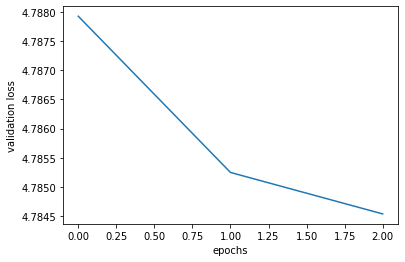

In [21]:
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

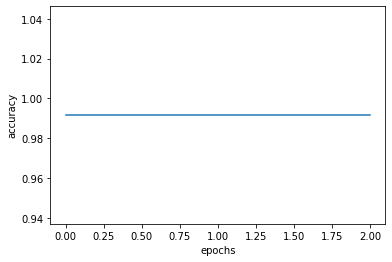

In [30]:
plt.plot(hist.history['binary_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [32]:
display(hist.history)

{'loss': [4.7904815673828125, 4.7871928215026855, 4.783790111541748],
 'binary_accuracy': [0.9916651248931885,
  0.9916651248931885,
  0.9916651248931885],
 'val_loss': [4.7879228591918945, 4.785250663757324, 4.784541130065918],
 'val_binary_accuracy': [0.9916656613349915,
  0.9916656017303467,
  0.9916656017303467]}

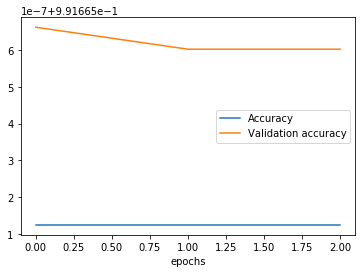

In [33]:
plt.plot(hist.history['binary_accuracy'],label="Accuracy")
plt.plot(hist.history['val_binary_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

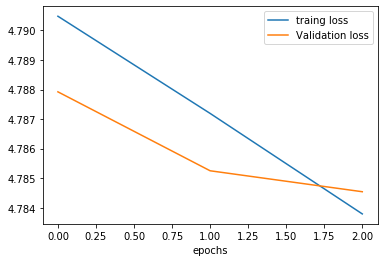

In [25]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

## Observations